In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import pyplot
import warnings
import json
import glob
warnings.filterwarnings('ignore')

In [2]:
l = [pd.read_json(filename) for filename in glob.glob("../../../paper/data/seoul/*.json")]
#l = [pd.read_json(filename) for filename in glob.glob("backups/seoul/*.json")]
df = pd.concat(l, axis=0, ignore_index = True, verify_integrity = True)
print(df)

       status                                     resolver       domain  \
0          ok                 https://dns.google/dns-query  netflix.com   
1          ok                 https://dns.google/dns-query   google.com   
2          ok              https://dns.aa.net.uk/dns-query   google.com   
3          ok              https://dns.aa.net.uk/dns-query  netflix.com   
4          ok   https://adfree.usableprivacy.net/dns-query  netflix.com   
...       ...                                          ...          ...   
197395     ok  https://anycast.uncensoreddns.org/dns-query  netflix.com   
197396     ok              https://sg.yepdns.com/dns-query   google.com   
197397     ok              https://sg.yepdns.com/dns-query  netflix.com   
197398     ok            https://doh.xfinity.com/dns-query   google.com   
197399     ok            https://doh.xfinity.com/dns-query  netflix.com   

              rtime  size_or_error   ping_time            datetime  
0        328.304033           

In [3]:
r = pd.read_json('resolver_geolocation.json')
ip_europe = r[(r['country_name']=='France') | (r['country_name']=='Austria') | (r['country_name']=='Russia') | (r['country_name']=='Netherlands') | (r['country_name']=='Spain') | (r['country_name']=='Luxembourg') | (r['country_name']=='Czechia')  | (r['country_name']=='Switzerland')  | (r['country_name']=='United Kingdom')  | (r['country_name']=='Finland')  | (r['country_name']=='Germany')  | (r['country_name']=='Sweden')  | (r['country_name']=='Denmark')]
ip_asia = r[(r['country_name']=='Cyprus') | (r['country_name']=='India') | (r['country_name']=='China') | (r['country_name']=='Japan') | (r['country_name']=='Singapore')  | (r['country_name']=='Indonesia') | (r['country_name']=='Hong Kong')| (r['country_name']=='Taiwan')]
ip_north_america = r[(r['country_name']=='United States') | (r['country_name']=='Canada') ]
ip_australia = r[(r['country_name']=='Australia')]
ip_not_found = r[(r['IP_address'] == 'None')]
r.head()

#Switch Cloudflare from Aus to NA
ip_australia = ip_australia.drop(labels=17, axis=0)
ip_australia = ip_australia.drop(labels=18, axis=0)
ip_australia = ip_australia.drop(labels=19, axis=0)

In [4]:
google = {'resolver':'https://dns.google/dns-query','IP_address':'8.8.8.8','country_iso_code':'US','country_name': 'United States', 'city_name':'None'}

cloudflare1 = {'resolver':'https://dns.cloudflare.com/dns-query','IP_address':'1.0.0.1','country_iso_code':'US','country_name': 'United States', 'city_name':'None'}
cloudflare2 = {'resolver':'https://family.cloudflare-dns.com/dns-query','IP_address':'1.0.0.3','country_iso_code':'US', 'country_name': 'United States', 'city_name':'None'}
cloudflare3 = {'resolver':'https://security.cloudflare-dns.com/dns-query','IP_address':'1.0.0.2','country_iso_code':'US', 'country_name': 'United States', 'city_name':'None'}

quad9_1 = {'resolver':'https://dns9.quad9.net/dns-query','IP_address':'9.9.9.9','country_iso_code':'US','country_name': 'United States', 'city_name':'Berkeley'}
quad9_2 = {'resolver':'https://dns9.quad9.net/dns-query','IP_address':'9.9.9.10','country_iso_code':'US','country_name': 'United States', 'city_name':'None'}

ordns = {'resolver':'https://ordns.he.net/dns-query','IP_address':'74.82.42.42','country_iso_code':'US','country_name': 'United States', 'city_name':'None'}

ip_north_america = ip_north_america.append(cloudflare1, ignore_index = True)
ip_north_america = ip_north_america.append(cloudflare2, ignore_index = True)
ip_north_america = ip_north_america.append(cloudflare3, ignore_index = True)

ip_asia = ip_asia.append(cloudflare1, ignore_index = True)
ip_asia = ip_asia.append(cloudflare2, ignore_index = True)
ip_asia = ip_asia.append(cloudflare3, ignore_index = True)

ip_europe = ip_europe.append(cloudflare1, ignore_index = True)
ip_europe = ip_europe.append(cloudflare2, ignore_index = True)
ip_europe = ip_europe.append(cloudflare3, ignore_index = True)

ip_europe = ip_europe.append(google, ignore_index = True)
ip_asia = ip_asia.append(google, ignore_index = True)

ip_asia = ip_asia.append(quad9_1, ignore_index = True)
ip_asia = ip_asia.append(quad9_2, ignore_index = True)

ip_europe = ip_europe.append(quad9_1, ignore_index = True)
ip_europe = ip_europe.append(quad9_2, ignore_index = True)

ip_europe = ip_europe.append(ordns, ignore_index = True)
ip_asia = ip_asia.append(ordns, ignore_index = True)

In [9]:
# Make a plot of median ping times vs. median query response times, grouped by resolver
AP_array_of_resolvers = pd.Series(ip_asia['resolver']).unique()
df_medians = df.loc[df.status == 'ok', ['resolver', 'rtime', 'ping_time']]
df_medians = df_medians[df_medians.resolver.isin(AP_array_of_resolvers)]
print(df_medians.resolver.unique())
df_medians = df_medians.groupby(['resolver']).median()
print(df_medians)
df_medians = df_medians[(df_medians.ping_time > 0)]
print(df_medians.resolver.unique())
df_medians = df_medians[(df_medians.rtime <= 1000)]
print(df_medians.resolver.unique())

fig, ax = plt.subplots()
plt.axline((0, 0), (0.33, 1), linewidth=2, color='r', zorder=-1, label='Three Round-Trips')
plt.axline((0, 0), (0.25, 1), linewidth=2, color='g', zorder=-1, label='Four Round-Trips')
sns.scatterplot(data=df_medians, x="ping_time", y="rtime", ax=ax, s=100)
ax.set_xlabel('ICMP Ping Latency (ms)', fontsize=20)
ax.set_ylabel('DoH Response Time (ms)', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)
plt.legend(fontsize=16)
plt.tight_layout()
plt.savefig("../../../paper/figures/Seoul_ping_qrt_scatter.pdf")

['https://dns.google/dns-query' 'https://dns.adguard.com/dns-query'
 'https://doh.in.ahadns.net/dns-query' 'https://dns.alidns.com/dns-query'
 'https://dns.arapurayil.com/dns-query'
 'https://doh.opendns.com/dns-query'
 'https://dns.cloudflare.com/dns-query'
 'https://family.cloudflare-dns.com/dns-query'
 'https://security.cloudflare-dns.com/dns-query'
 'https://dns.therifleman.name/dns-query' 'https://doh.pub/dns-query'
 'https://doh-jp.blahdns.com/dns-query'
 'https://doh-sg.blahdns.com/dns-query' 'https://ordns.he.net/dns-query'
 'https://public.dns.iij.jp/dns-query' 'https://doh.this.web.id/dns-query'
 'https://dns.twnic.tw/dns-query' 'https://dns9.quad9.net/dns-query'
 'https://sg.yepdns.com/dns-query']
                                                      rtime   ping_time
resolver                                                               
https://dns.adguard.com/dns-query                205.226110   69.868565
https://dns.alidns.com/dns-query                 254.773720   63.2

AttributeError: 'DataFrame' object has no attribute 'resolver'

In [5]:
# Median of each resolver in ascending order(removed the ones with nan)
NA_array_of_resolvers = pd.Series(ip_north_america['resolver']).unique()

NA_df = df.loc[df.resolver.isin(NA_array_of_resolvers)]
#print(NA_df)

NA_medians = NA_df.groupby('resolver').rtime.median()
print(NA_medians)

NA_medians = NA_medians.dropna()
NA_medians = NA_medians[NA_medians > 0]
NA_medians = NA_medians.sort_values(ascending=False)
#print(NA_medians)

resolver
https://adblock.doh.mullvad.net/dns-query        255.952454
https://dns.cloudflare.com/dns-query              17.011637
https://dns.google/dns-query                     139.511926
https://dns.nextdns.io/dns-query                 205.640748
https://dns1.dnscrypt.ca/dns-query                      NaN
https://dns2.dnscrypt.ca/dns-query                      NaN
https://dns9.quad9.net/dns-query                 101.529019
https://doh.cleanbrowsing.org/dns-query                 NaN
https://doh.la.ahadns.net/dns-query              434.356131
https://doh.mullvad.net/dns-query                279.858055
https://doh.post-factum.tk/dns-query                    NaN
https://doh.xfinity.com/dns-query                871.730379
https://dohtrial.att.net/dns-query               663.899716
https://draco.plan9-ns2.com/dns-query            637.543221
https://family.cloudflare-dns.com/dns-query      114.560462
https://ordns.he.net/dns-query                   104.828180
https://security.cloudflare-dns

In [6]:
#Median of each resolver in NA (removed the ones with nan)

NA_array_of_resolvers = pd.Series(ip_north_america['resolver']).unique()

NA_dict_resp_time_series={}
NA_length=len(NA_array_of_resolvers)

NA_both_resp=[0]*NA_length
NA_resp_time_series=[0]*NA_length

for i in range(NA_length):
    NA_both_resp[i]=df[(df['resolver']==NA_array_of_resolvers[i])]
    NA_resp_time_series[i]=(NA_both_resp[i]['rtime'])
    y_axis = NA_array_of_resolvers
    NA_temp = [s.replace("https://", "") for s in y_axis]
    NA_new_list = [s.replace("/dns-query", "") for s in NA_temp]
    NA_dict_resp_time_series[NA_new_list[i]]= NA_resp_time_series[i]
NA_frame_to_plot=pd.DataFrame(NA_dict_resp_time_series)

medians = NA_frame_to_plot.median()
medians.sort_values(ascending=False, inplace=True)
NA_response_times = NA_frame_to_plot[medians.index]

NA_clear=[]
for a in range(len(NA_new_list)):
    x = NA_new_list[a]
    if NA_response_times[x].count() != 0.0:
        print (x, ":", NA_response_times[x].median())
        NA_clear.append(x)
#print(NA_clear)

dns.google : 139.51192550000002
doh.la.ahadns.net : 434.356131
dohtrial.att.net : 663.8997159999999
ordns.he.net : 104.82818
adblock.doh.mullvad.net : 255.952454
doh.mullvad.net : 279.8580555
dns.nextdns.io : 205.6407475
draco.plan9-ns2.com : 637.543221
dns9.quad9.net : 101.529019
doh.xfinity.com : 871.730379
dns.cloudflare.com : 17.011637
family.cloudflare-dns.com : 114.560462
security.cloudflare-dns.com : 114.126633


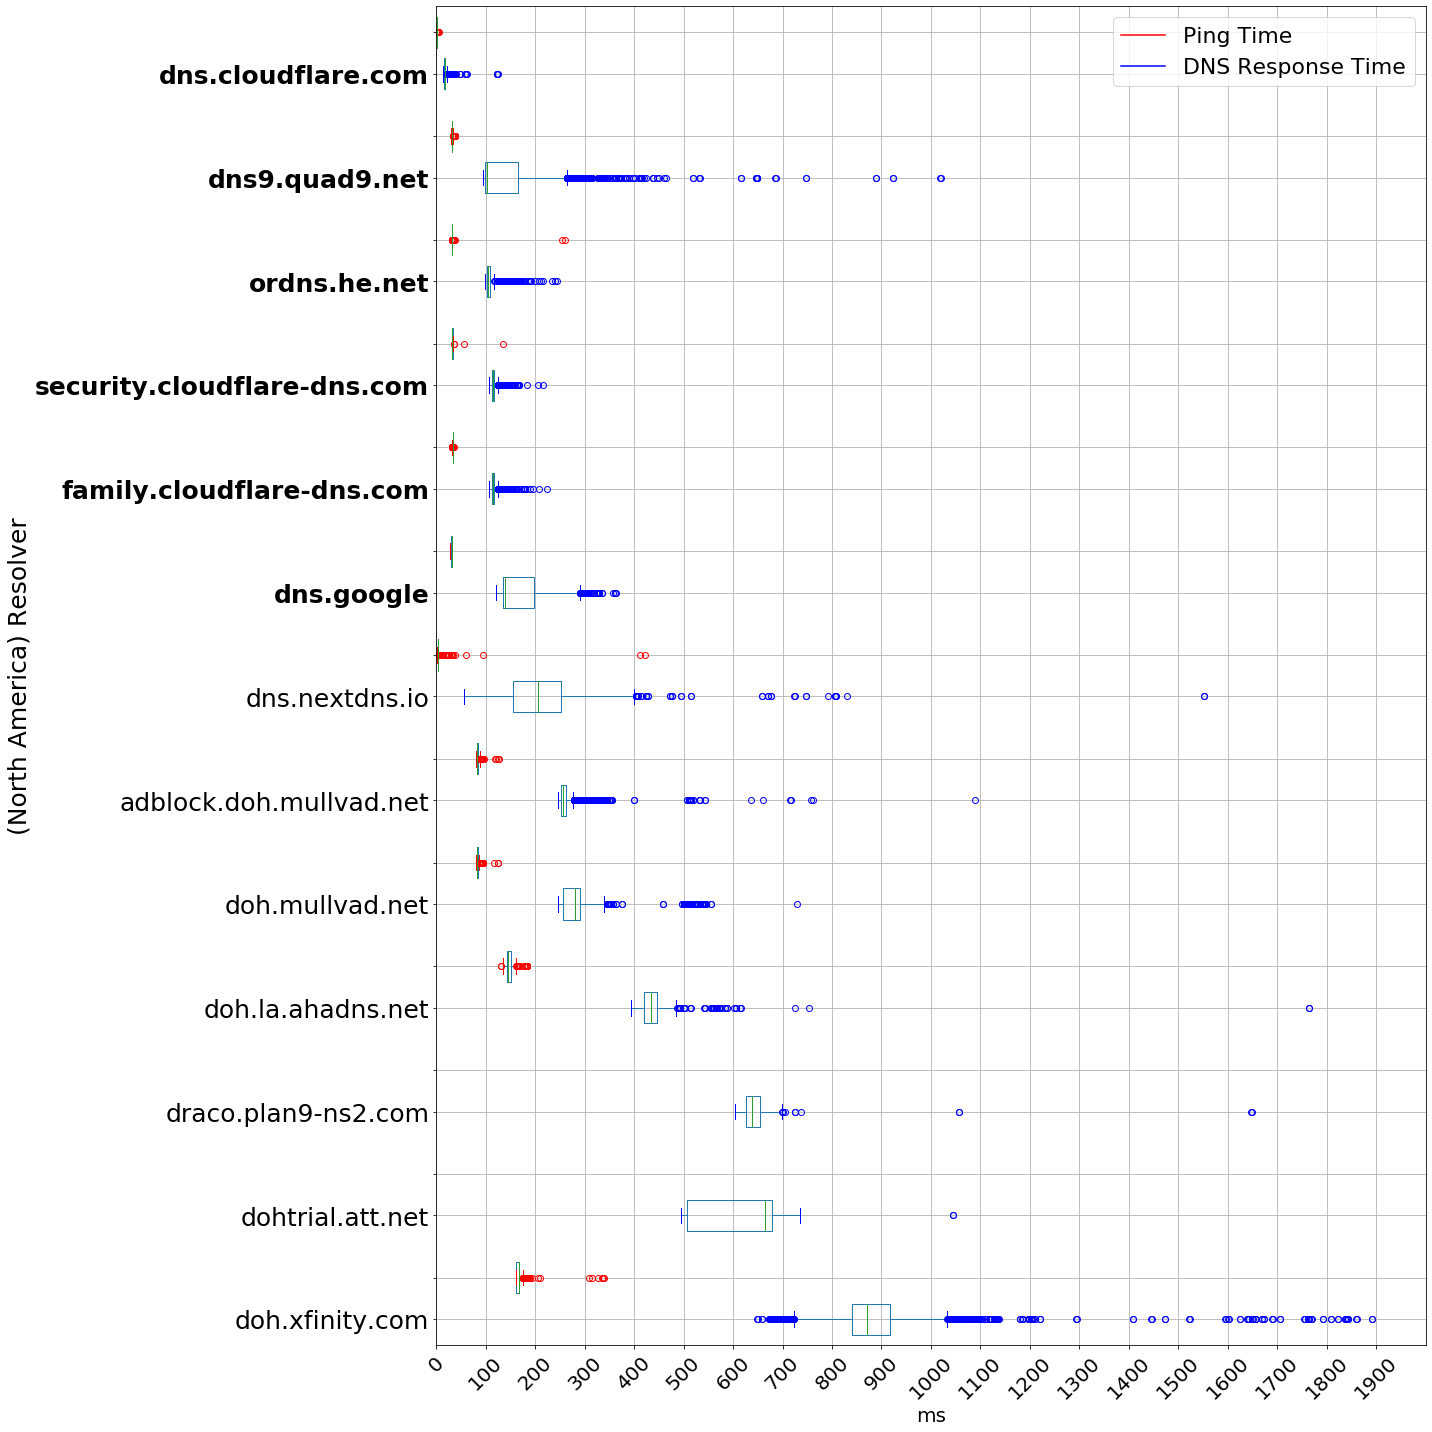

In [14]:
## This boxplot sorts by ascending order of DNS response time

# North America Boxplot
NA_array_of_resolvers = pd.Series(ip_north_america['resolver']).unique()

NA_dict_resp_time_series={}
NA_length=len(NA_array_of_resolvers)

NA_both_resp=[0]*NA_length
NA_resp_time_series=[0]*NA_length

for i in range(NA_length):
    NA_both_resp[i]=df[(df['resolver']==NA_array_of_resolvers[i])]
    NA_resp_time_series[i]=(NA_both_resp[i]['rtime'])
    y_axis = NA_array_of_resolvers
    NA_temp = [s.replace("https://", "") for s in y_axis]
    NA_new_list = [s.replace("/dns-query", "") for s in NA_temp]
    if(NA_new_list[i] in NA_clear):
        NA_dict_resp_time_series[NA_new_list[i]]= NA_resp_time_series[i]
NA_frame_to_plot=pd.DataFrame(NA_dict_resp_time_series)


# North America Boxplot for Ping Time

NA_dict_ping_series={}


NA_both_ping=[0]*NA_length
NA_ping_series = [0]*NA_length
for i in range(NA_length):
    NA_both_ping[i]=df[(df['resolver']==NA_array_of_resolvers[i])]
    NA_ping_series[i]=(NA_both_ping[i]['ping_time'])
    y_axis = NA_array_of_resolvers
    NA_temp = [s.replace("https://", "") for s in y_axis]
    NA_new_list = [s.replace("/dns-query", "") for s in NA_temp]
    if(NA_new_list[i] in NA_clear):
        NA_dict_ping_series[NA_new_list[i]]= NA_ping_series[i]
NA_ping_frame_to_plot=pd.DataFrame(NA_dict_ping_series)
NA_ping = NA_ping_frame_to_plot


#Make two plots and merge
c = "blue"
z = "red"



medians = NA_frame_to_plot.median()
medians.sort_values(ascending=False, inplace=True)
ping_times = NA_ping[medians.index]
NA_response_times = NA_frame_to_plot[medians.index]


NA_boxplot = NA_response_times.boxplot(vert=False,figsize=(20,20),showfliers=True,capprops=dict(color=c),whiskerprops=dict(color=c),flierprops=dict(color=c, markeredgecolor=c),medianprops=dict(color=c), meanprops=dict(color=c),  positions=np.array(range(len(NA_dict_resp_time_series)))*2.0-0.4, widths=0.6)
NA_ping_boxplot = ping_times.boxplot(vert=False,figsize=(20,20),showfliers=True,capprops=dict(color=z),whiskerprops=dict(color=z),flierprops=dict(color=z, markeredgecolor=z),medianprops=dict(color=z), meanprops=dict(color=z), positions=np.array(range(len(NA_dict_ping_series)))*2.0+0.4, widths=0.6)

plt.plot([], c='red', label='Ping Time')
plt.plot([], c='blue', label='DNS Response Time')
plt.legend(loc = 'upper right', fontsize=22)

xl = 2000
plt.xlim(0,xl)
plt.xlabel('ms', fontsize=20)
plt.xticks(rotation=45, fontsize=20)
plt.yticks(fontsize=25)
plt.ylabel('(North America) Resolver', fontsize=25)
plt.gca().get_yticklabels()[12].set_weight("bold")
plt.gca().get_yticklabels()[11].set_weight("bold")
plt.gca().get_yticklabels()[10].set_weight("bold")
plt.gca().get_yticklabels()[9].set_weight("bold")
plt.gca().get_yticklabels()[8].set_weight("bold")
plt.gca().get_yticklabels()[7].set_weight("bold")

#plt.xscale('log')

plt.xticks(np.arange(0, xl, step=100))
plt.tight_layout()
plt.grid(True)
plt.savefig("../../../paper/figures/Seoul_North_America_Full.pdf")
plt.show()

In [8]:
# Median of each resolver in ascending order (removed the ones with nan) 
asia_array_of_resolvers = pd.Series(ip_asia['resolver']).unique()

asia_df = df.loc[df.resolver.isin(asia_array_of_resolvers)]
#print(asia_df)

asia_medians = asia_df.groupby('resolver').rtime.median()
#print(asia_medians)

asia_medians = asia_medians.dropna()
asia_medians = asia_medians[asia_medians > 0]
#asia_medians = asia_medians.sort_values(ascending=False)
print(asia_medians)

resolver
https://dns.adguard.com/dns-query                  205.226110
https://dns.alidns.com/dns-query                   254.773720
https://dns.arapurayil.com/dns-query               359.232118
https://dns.cloudflare.com/dns-query                17.011637
https://dns.google/dns-query                       139.511926
https://dns.therifleman.name/dns-query             449.428851
https://dns.twnic.tw/dns-query                   31606.619491
https://dns9.quad9.net/dns-query                   101.529019
https://doh-jp.blahdns.com/dns-query               109.622501
https://doh-sg.blahdns.com/dns-query               214.445051
https://doh.in.ahadns.net/dns-query                455.553819
https://doh.opendns.com/dns-query                  206.942881
https://doh.pub/dns-query                          129.598772
https://doh.this.web.id/dns-query                 1068.850020
https://family.cloudflare-dns.com/dns-query        114.560462
https://ordns.he.net/dns-query                     104.828180

In [9]:
#Median of each resolver in Asia (removed the ones with nan)

asia_array_of_resolvers = pd.Series(ip_asia['resolver']).unique()

asia_dict_resp_time_series={}
asia_length=len(asia_array_of_resolvers)

asia_both_resp=[0]*asia_length
asia_resp_time_series=[0]*asia_length

for i in range(asia_length):
    asia_both_resp[i]=df[(df['resolver']==asia_array_of_resolvers[i])]
    asia_resp_time_series[i]=(asia_both_resp[i]['rtime'])
    y_axis = asia_array_of_resolvers
    asia_temp = [s.replace("https://", "") for s in y_axis]
    asia_new_list = [s.replace("/dns-query", "") for s in asia_temp]
    asia_dict_resp_time_series[asia_new_list[i]]= asia_resp_time_series[i]
asia_frame_to_plot=pd.DataFrame(asia_dict_resp_time_series)

medians = asia_frame_to_plot.median()
medians.sort_values(ascending=False, inplace=True)
asia_response_times = asia_frame_to_plot[medians.index]

asia_clear=[]
for a in range(len(asia_new_list)):
    x = asia_new_list[a]
    if asia_response_times[x].count() != 0.0:
        print (x, ":", asia_response_times[x].median())
        asia_clear.append(x)
#print(asia_clear)

dns.adguard.com : 205.2261095
doh.in.ahadns.net : 455.553819
dns.alidns.com : 254.7737205
dns.arapurayil.com : 359.232118
doh.opendns.com : 206.942881
dns.therifleman.name : 449.428851
doh.pub : 129.598772
doh-jp.blahdns.com : 109.622501
doh-sg.blahdns.com : 214.445051
public.dns.iij.jp : 200.823172
doh.this.web.id : 1068.85002
dns.twnic.tw : 31606.6194905
sg.yepdns.com : 238.0060815
dns.cloudflare.com : 17.011637
family.cloudflare-dns.com : 114.560462
security.cloudflare-dns.com : 114.126633
dns.google : 139.51192550000002
dns9.quad9.net : 101.529019
ordns.he.net : 104.82818


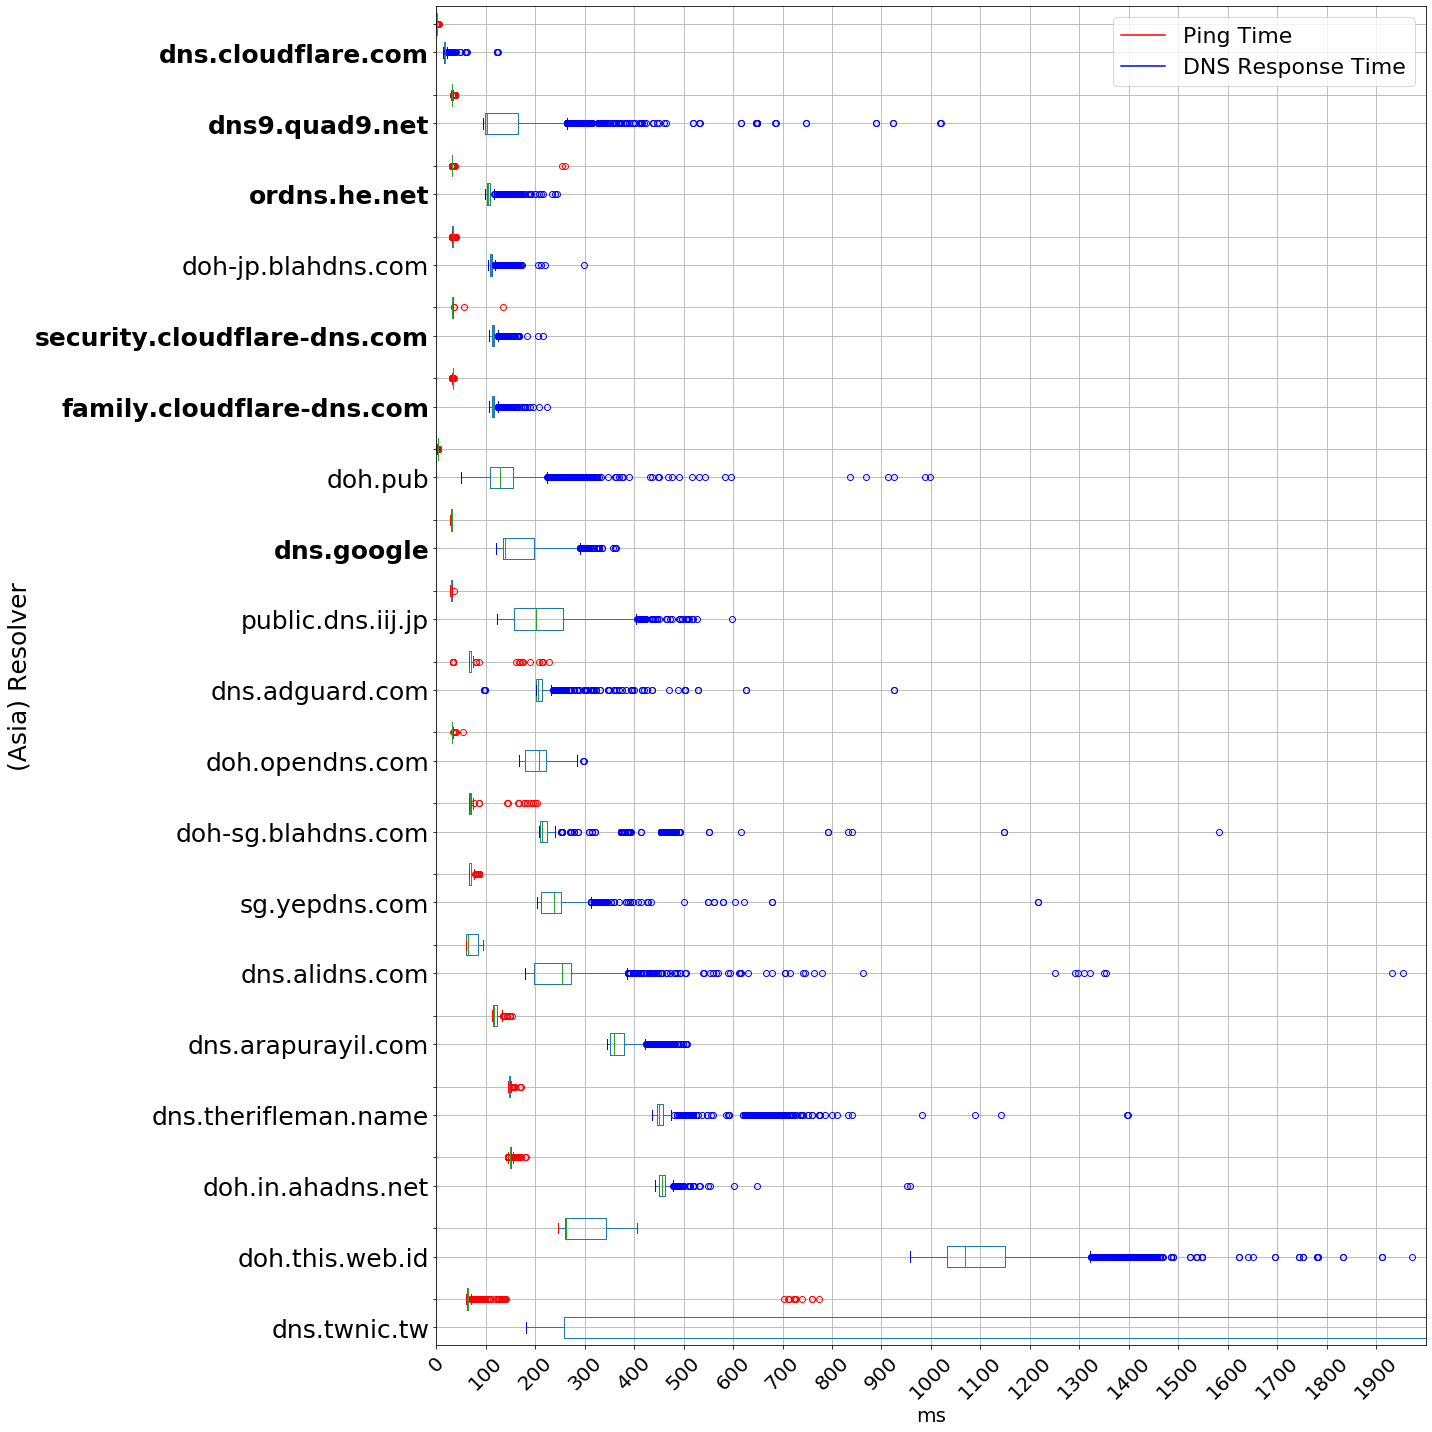

In [15]:
## This boxplot sorts by ascending order of DNS response time

# Asia Boxplot
asia_array_of_resolvers = pd.Series(ip_asia['resolver']).unique()

asia_dict_resp_time_series={}
asia_length=len(asia_array_of_resolvers)

asia_both_resp=[0]*asia_length
asia_resp_time_series=[0]*asia_length

for i in range(asia_length):
    asia_both_resp[i]=df[(df['resolver']==asia_array_of_resolvers[i])]
    asia_resp_time_series[i]=(asia_both_resp[i]['rtime'])
    y_axis = asia_array_of_resolvers
    asia_temp = [s.replace("https://", "") for s in y_axis]
    asia_new_list = [s.replace("/dns-query", "") for s in asia_temp]
    if(asia_new_list[i] in asia_clear):
        asia_dict_resp_time_series[asia_new_list[i]]= asia_resp_time_series[i]
asia_frame_to_plot=pd.DataFrame(asia_dict_resp_time_series)


# Asia Boxplot for Ping Time

asia_dict_ping_series={}


asia_both_ping=[0]*asia_length
asia_ping_series = [0]*asia_length
for i in range(asia_length):
    asia_both_ping[i]=df[(df['resolver']==asia_array_of_resolvers[i])]
    asia_ping_series[i]=(asia_both_ping[i]['ping_time'])
    y_axis = asia_array_of_resolvers
    asia_temp = [s.replace("https://", "") for s in y_axis]
    asia_new_list = [s.replace("/dns-query", "") for s in asia_temp]
    if(asia_new_list[i] in asia_clear):
        asia_dict_ping_series[asia_new_list[i]]= asia_ping_series[i]
asia_ping_frame_to_plot=pd.DataFrame(asia_dict_ping_series)
asia_ping = asia_ping_frame_to_plot


#Make two plots and merge
c = "blue"
z = "red"


medians = asia_frame_to_plot.median()
medians.sort_values(ascending=False, inplace=True)
ping_times = asia_ping[medians.index]
asia_response_times = asia_frame_to_plot[medians.index]


asia_boxplot = asia_response_times.boxplot(vert=False,figsize=(20,20),showfliers=True,capprops=dict(color=c),whiskerprops=dict(color=c),flierprops=dict(color=c, markeredgecolor=c),medianprops=dict(color=c), meanprops=dict(color=c),  positions=np.array(range(len(asia_dict_resp_time_series)))*2.0-0.4, widths=0.6)
asia_ping_boxplot = ping_times.boxplot(vert=False,figsize=(20,20),showfliers=True,capprops=dict(color=z),whiskerprops=dict(color=z),flierprops=dict(color=z, markeredgecolor=z),medianprops=dict(color=z), meanprops=dict(color=z), positions=np.array(range(len(asia_dict_ping_series)))*2.0+0.4, widths=0.6)

plt.plot([], c='red', label='Ping Time')
plt.plot([], c='blue', label='DNS Response Time')

plt.legend(loc = 'upper right', fontsize=22)

xl = 2000
plt.xlim(0,xl)
plt.xlabel('ms', fontsize=20)
plt.ylabel('(Asia) Resolver', fontsize=25)
plt.gca().get_yticklabels()[18].set_weight("bold")
plt.gca().get_yticklabels()[17].set_weight("bold")
plt.gca().get_yticklabels()[16].set_weight("bold")
plt.gca().get_yticklabels()[14].set_weight("bold")
plt.gca().get_yticklabels()[13].set_weight("bold")
plt.gca().get_yticklabels()[11].set_weight("bold")
plt.xticks(np.arange(0, xl, step=100), rotation=45,fontsize=20)
plt.yticks(fontsize=25)
plt.grid(True)
plt.tight_layout()
plt.savefig("../../../paper/figures/Seoul_Asia_Full.pdf")
plt.show()

In [11]:
# Median of each resolver in ascending order (removed the ones with nan) 
eur_array_of_resolvers = pd.Series(ip_europe['resolver']).unique()

eur_df = df.loc[df.resolver.isin(eur_array_of_resolvers)]
#print(eur_df)

eur_medians = eur_df.groupby('resolver').rtime.median()
#print(eur_medians)

eur_medians = eur_medians.dropna()
eur_medians = eur_medians[eur_medians > 0]
#eur_medians = eur_medians.sort_values(ascending=False)
print(eur_medians)

resolver
https://adfree.usableprivacy.net/dns-query                    785.818908
https://anycast.uncensoreddns.org/dns-query                   757.208443
https://dns-doh-no-safe-search.dnsforfamily.com/dns-query    1159.709329
https://dns-doh.dnsforfamily.com/dns-query                   1162.268442
https://dns-family.adguard.com/dns-query                      205.205942
https://dns.aa.net.uk/dns-query                              1045.910521
https://dns.circl.lu/dns-query                                812.269371
https://dns.cloudflare.com/dns-query                           17.011637
https://dns.digitale-gesellschaft.ch/dns-query                711.035871
https://dns.dnshome.de/dns-query                             1050.853875
https://dns.google/dns-query                                  139.511926
https://dns.njal.la/dns-query                                1094.074531
https://dns.switch.ch/dns-query                               720.364554
https://dns1.ryan-palmer.com/dns-query    

In [12]:
#Median of each resolver in Europe (removed the ones with nan)

eur_array_of_resolvers = pd.Series(ip_europe['resolver']).unique()

eur_dict_resp_time_series={}
eur_length=len(eur_array_of_resolvers)

eur_both_resp=[0]*eur_length
eur_resp_time_series=[0]*eur_length

for i in range(eur_length):
    eur_both_resp[i]=df[(df['resolver']==eur_array_of_resolvers[i])]
    eur_resp_time_series[i]=(eur_both_resp[i]['rtime'])
    y_axis = eur_array_of_resolvers
    eur_temp = [s.replace("https://", "") for s in y_axis]
    eur_new_list = [s.replace("/dns-query", "") for s in eur_temp]
    eur_dict_resp_time_series[eur_new_list[i]]= eur_resp_time_series[i]
eur_frame_to_plot=pd.DataFrame(eur_dict_resp_time_series)

medians = eur_frame_to_plot.median()
medians.sort_values(ascending=False, inplace=True)
eur_response_times = eur_frame_to_plot[medians.index]

eur_clear=[]
for a in range(len(eur_new_list)):
    x = eur_new_list[a]
    if eur_response_times[x].count() != 0.0:
        print (x, ":", eur_response_times[x].median())
        eur_clear.append(x)
#print(eur_clear)

dns.aa.net.uk : 1045.910521
adfree.usableprivacy.net : 785.8189075
dns-family.adguard.com : 205.2059425
doh.nl.ahadns.net : 749.7373805
dnsnl-noads.alekberg.net : 1023.802727
dnsnl.alekberg.net : 1022.8219875
dnses.alekberg.net : 947.4526635
dns.circl.lu : 812.269371
odvr.nic.cz : 826.0262335
dns.digitale-gesellschaft.ch : 711.035871
dns1.ryan-palmer.com : 778.549751
dns-doh.dnsforfamily.com : 1162.268442
dns-doh-no-safe-search.dnsforfamily.com : 1159.7093285
dnsforge.de : 1043.0262275
dns.dnshome.de : 1050.853875
doh-ch.blahdns.com : 688.7389015
doh-de.blahdns.com : 796.864714
doh-fi.blahdns.com : 860.539471
ibksturm.synology.me : 1254.4700785
doh.ffmuc.net : 1309.8788425
doh.libredns.gr : 828.113687
dns.njal.la : 1094.0745305
dnsse.alekberg.net : 1032.28667
dns.switch.ch : 720.3645535
unicast.uncensoreddns.org : 758.4658555000001
anycast.uncensoreddns.org : 757.2084434999999
dns.cloudflare.com : 17.011637
family.cloudflare-dns.com : 114.560462
security.cloudflare-dns.com : 114.126633

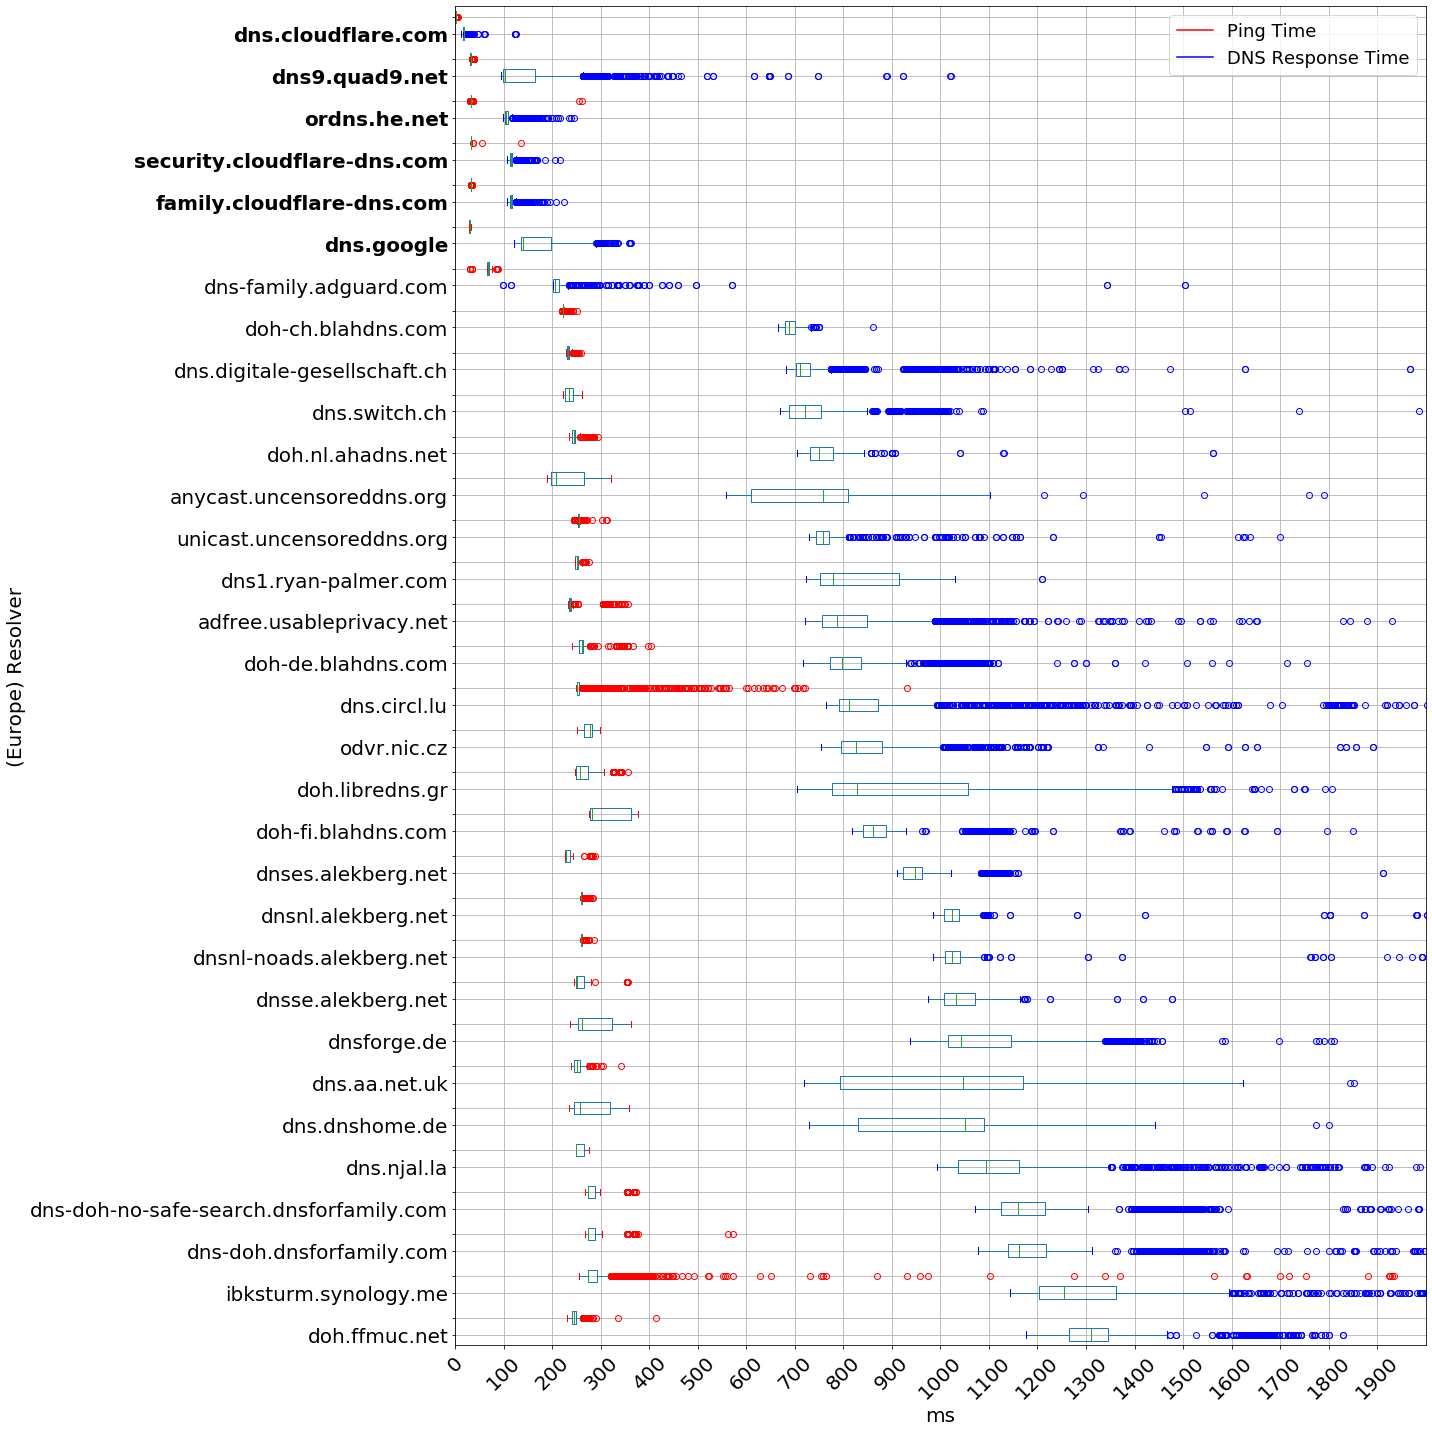

In [16]:
## This boxplot sorts by ascending order of DNS response time
# Europe Boxplot
eur_array_of_resolvers = pd.Series(ip_europe['resolver']).unique()

eur_dict_resp_time_series={}
eur_length=len(eur_array_of_resolvers)

eur_both_resp=[0]*eur_length
eur_resp_time_series=[0]*eur_length

for i in range(eur_length):
    eur_both_resp[i]=df[(df['resolver']==eur_array_of_resolvers[i])]
    eur_resp_time_series[i]=(eur_both_resp[i]['rtime'])
    y_axis = eur_array_of_resolvers
    eur_temp = [s.replace("https://", "") for s in y_axis]
    eur_new_list = [s.replace("/dns-query", "") for s in eur_temp]
    if(eur_new_list[i] in eur_clear):
        eur_dict_resp_time_series[eur_new_list[i]]= eur_resp_time_series[i]
eur_frame_to_plot=pd.DataFrame(eur_dict_resp_time_series)


# Europe Boxplot for Ping Time

eur_dict_ping_series={}


eur_both_ping=[0]*eur_length
eur_ping_series = [0]*eur_length
for i in range(eur_length):
    eur_both_ping[i]=df[(df['resolver']==eur_array_of_resolvers[i])]
    eur_ping_series[i]=(eur_both_ping[i]['ping_time'])
    y_axis = eur_array_of_resolvers
    eur_temp = [s.replace("https://", "") for s in y_axis]
    eur_new_list = [s.replace("/dns-query", "") for s in eur_temp]
    if(eur_new_list[i] in eur_clear):
        eur_dict_ping_series[eur_new_list[i]]= eur_ping_series[i]
eur_ping_frame_to_plot=pd.DataFrame(eur_dict_ping_series)
eur_ping = eur_ping_frame_to_plot


#Make two plots and merge
c = "blue"
z = "red"


medians = eur_frame_to_plot.median()
medians.sort_values(ascending=False, inplace=True)
ping_times = eur_ping[medians.index]
eur_response_times = eur_frame_to_plot[medians.index]


eur_boxplot = eur_response_times.boxplot(vert=False,figsize=(20,20),showfliers=True,capprops=dict(color=c),whiskerprops=dict(color=c),flierprops=dict(color=c, markeredgecolor=c),medianprops=dict(color=c), meanprops=dict(color=c),  positions=np.array(range(len(eur_dict_resp_time_series)))*2.0-0.4, widths=0.6)
eur_ping_boxplot = ping_times.boxplot(vert=False,figsize=(20,20),showfliers=True,capprops=dict(color=z),whiskerprops=dict(color=z),flierprops=dict(color=z, markeredgecolor=z),medianprops=dict(color=z), meanprops=dict(color=z), positions=np.array(range(len(eur_dict_ping_series)))*2.0+0.4, widths=0.6)

plt.plot([], c='red', label='Ping Time')
plt.plot([], c='blue', label='DNS Response Time')
plt.legend(loc = 'upper right', fontsize=18)

xl = 2000
plt.xlim(0,xl)
plt.xlabel('ms', fontsize=20)
plt.ylabel('(Europe) Resolver', fontsize=20)
plt.gca().get_yticklabels()[31].set_weight("bold")
plt.gca().get_yticklabels()[30].set_weight("bold")
plt.gca().get_yticklabels()[29].set_weight("bold")
plt.gca().get_yticklabels()[28].set_weight("bold")
plt.gca().get_yticklabels()[27].set_weight("bold")
plt.gca().get_yticklabels()[26].set_weight("bold")
plt.xticks(np.arange(0, xl, step=100),rotation=45, fontsize=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.tight_layout()
plt.savefig("../../../paper/figures/Seoul_Europe_Full.pdf")
plt.show()